# Synthethic Dataset

### Creating a synthetic dataset of multi-digit images from the MNIST dataset 

---

This notebook explains my approach to creating a synthetic dataset of 64x64 images of digit sequences from the MNIST Handwritten Digit Database. The resulting dataset is fairly simple compared to the original SVHN dataset, but it allows us to quickly develop and experiment with model architectures for recognizing multiple digits in a single image.

Our resulting dataset consists of 50,000 greyscale images of size 64 x 64 where we have 10,000 examples for each possible sequence length. We randomly select the images that are concatenated from the original MNIST dataset. These images are then scaled down to 12 x 12 pixels (since 5 x 12 < 64) this allows us to fit up to 5 images horizontally. These images are then concatenated and centered both horizontally and vertically in the resulting image.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

## Loading the MNIST dataset

Let's load the MNIST dataset using the ``sklearn.datasets`` package for convinience.

In [4]:
from sklearn import datasets, preprocessing
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')# Fetch the MNIST dataset from mldata.org
#mnist = datasets.fetch_mldata('MNIST original')

# Extract the data and labels
X, y = mnist.data.astype(float), mnist.target.astype(int)

print("Original Shape")
print(X.shape, y.shape)

# Reshape the original dataset which is flat to 28x28 images
X = X.reshape(len(X), 28, 28)

print("\nNew Shape")
print(X.shape)

Original Shape
(70000, 784) (70000,)

New Shape
(70000, 28, 28)


Let's implement a few helper functions to help us to visually explore our data.

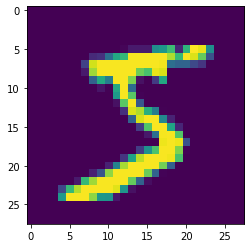

In [5]:
def plot_image(img):
    """Helper function for displaying a single image
    """
    plt.imshow(img, interpolation='nearest')

def plot_images(img, labels, nrows, ncols):
    """Helper function used to display digits
    """
    plt.figure(figsize=(min(16, ncols*2), min(16, nrows*2)))
    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i+1)
        # Reshape every image to a square array 2d array
        if img[i].shape == (64, 64, 1):
            plt.imshow(img[i,:,:,0], interpolation='nearest')
        else:
            plt.imshow(img[i], interpolation='nearest')
        plt.xticks([]); plt.yticks([])
        plt.title(labels[i])
        

# Display a single image
plot_image(X[0])

Let's plot a few more digits to get a better sense of what the data looks like.

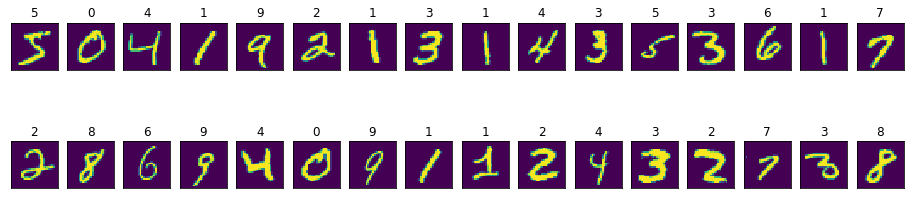

In [6]:
# Plot 2 rows with 16 digits each
plot_images(X, y, 2, 16)  

Looks like our dataset is ordered by label, let's randomly sort the arrays to view some of the other numbers as well

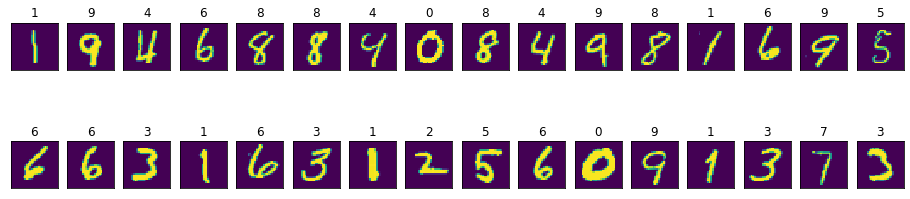

In [7]:
from sklearn.utils import shuffle

# Shuffle the dataset
X, y = shuffle(X, y)

# Plot 2 rows with 16 digits each
plot_images(X, y, 2, 16)

## Creating the synthetic dataset

Let's create a synthetic dataset consisting of sequences of up to 5 digits using the MNIST dataset. Let's start by specifying the new dimensions, the maximum number of digits and the size of our new dataset for convenience.

In [8]:
# Height and width of our new synthethic images
height, width = 64, 64

# Maximum number of digits
max_digits = 5

# Scale the origina images down to 45% (12x12 pixels)
scale = 0.45

# New height and width of the scaled images
new_height, new_width = 12, 12

# We create a new dataset with 50,000 images
dataset_size = 50000

### Concatenating the images and labels

Here is a simple function to concatenate a set of images into a single larger image and center the digit sequence within the new image. The following bulletpoints outline the procedure:

* By scaling the image to 45% we get a 12 x 12 image
* If we concatenate, say 3 images our resulting image will be 12 x 36 pixels
* To center this image horizontally we must calculate the padding on each side, which is (64 - 36) / 2 = 14
* To center it vertically we know that our new image is 64 pixels high and that our scaled images are 12 x 12 pixels. This means that we must pad the image with (64 - 12) / 2 = 26 pixels vertically.

In [23]:
a = (int)(2.0)
a

2

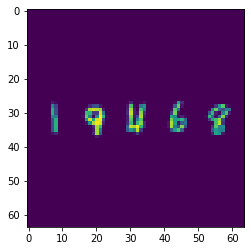

In [24]:
#from scipy.misc import imresize
from skimage.transform import resize as imresize
def concat_images(images):
    # Keep this
    num_digits = len(images)    
    
    # Initialize a numpy array for the new image
    new_image = np.zeros(shape=(height, width), dtype="uint8")
    
    # Calculate the horizontal and vertical padding
    y_pad = (int)((height - new_height) / 2)
    x_pad = (int)((width - num_digits * new_width) / 2)
    
    # For every image passed to the function
    for i in range(num_digits):
                         
        # Scale down the original image
        scaled = imresize(images[i] ,output_shape = (12,12))
        
        # Calculate the starting position
        x_offset = x_pad + (i*new_width)
        
        # Add the scaled image to the new image
        new_image[y_pad:height-y_pad, x_offset:x_offset+new_width] = scaled
        
    # Return the newly centered image
    return new_image


# Concatenate image 0 through 5 to a single image
plot_image(concat_images(X[0:5]))

We also need a new label structure for our newly created images. Let's represent each label as a list where each element represents the digit in the sequence. For sequences with less than 5 digits we use 10 as a filler to represent missing values.

In [25]:
def concat_labels(labels, num_images=5):
    """ Concatenates a set of set of labels into a single numpy array
    """
    new_label = np.zeros(num_images, dtype=int)
    for i in range(num_images):
        if i < len(labels):
            new_label[i] = labels[i]
        else:
            new_label[i] = 10
    return new_label


# Concatenate the labels for image 0 through 5
concat_labels(y[:5])

array([1, 9, 4, 6, 8])

Let's test the function to see that we are able to generate some images with different number of digits and that our new labels match the images

array([1, 9, 4, 6, 8])

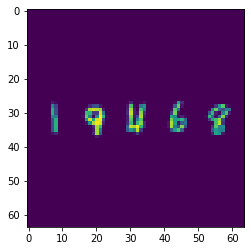

In [26]:
# Display images 0 through 5
plot_image(concat_images(X[:5]))

# Print the label for the new image
concat_labels(y[:5])

array([ 1,  9,  4, 10, 10])

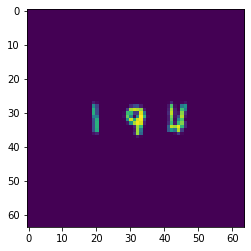

In [27]:
# Display images 0 through 3
plot_image(concat_images(X[:3]))

# Print the labels for the new image
concat_labels(y[:3])

array([ 1, 10, 10, 10, 10])

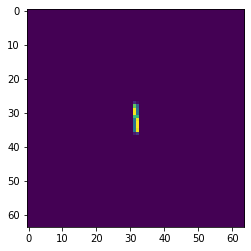

In [28]:
# Display the first image
plot_image(concat_images(X[:1]))

# Print the new label
concat_labels(y[:1])

### Dataset generator

Let's write a simple function that will help us to generate our synthetic dataset. The function will create an even number of samples for the different digit sequence length. E.g, if we want to create 50,000 images we will get 10,000 images with a single digit, 20,000 images with 2 digits etc.

In [34]:
import random
def generate_digit_sequences(data, labels, n):
    """ Helper function for automatically generating a new dataset of digit sequences
    """
    num =0
    # Initialize numpy arrays
    X = np.zeros(shape=(n, height, width), dtype='uint8')
    y = np.zeros(shape=(n, max_digits), dtype=np.int32)
    
    # Number of training examples of each sequence length
    n_samples =(int)(n / max_digits)
    
    # For every possible digit sequence length
    for i in range(1, max_digits+1):
        
        # Pick n_samples images
        for j in range((i-1)*n_samples, i*n_samples):
            
            # Select i random digits from the original dataset
            selection = random.sample(range(0, len(data)), i)
            
            # Concatenate the digits and labels from
            X[j] = concat_images(data[selection])
            y[j] = concat_labels(labels[selection])
            print(num)
            num = num+1     
    # Add an additional dimension to the image array
    X = np.expand_dims(X, axis=3)
            
    # Return the new dataset
    return X, y


# Generate a synthetic dataset of digit sequences with 50,000 new images
X_new, y_new = generate_digit_sequences(X, y, 10000)

print("Images", X_new.shape)
print("Labels", y_new.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149


3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822


5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498


6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137


8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761
8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793


#### Class Balance and sequence lengths

Let's verify that our dataset is fairly balanced in terms of the individual digits (0-9) and that we actually generated a dataset with an even distribution of digit sequence lengths.

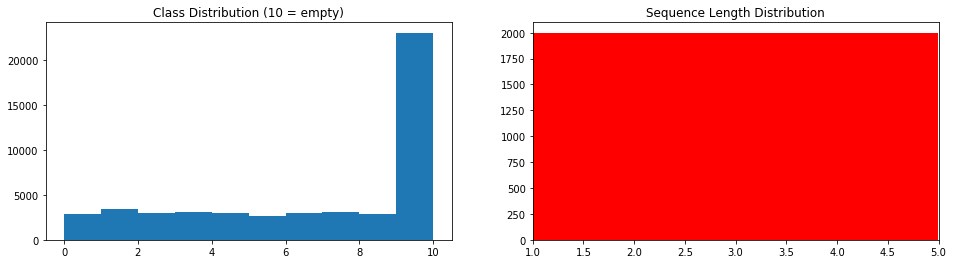

In [35]:
# Plot a histogram showing the class distribution
plt.subplot2grid((1, 2), (0, 0))
plt.hist(y_new.flatten())
plt.title("Class Distribution (10 = empty)")

# Plot a histogram showing the sequence length distribution
plt.subplot2grid((1, 2), (0, 1))
plt.hist((y_new != 10).sum(1), color='r', bins=5)
plt.xlim(1, 5)
plt.title("Sequence Length Distribution");

The histogram looks ok. As expected we have an overweight of 10's that are used to represent missing numbers.

### Sanity Check

Let's do a sanity check of our dataset to make sure that our images looks ok and that our labels match the images.

/home/suraj/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


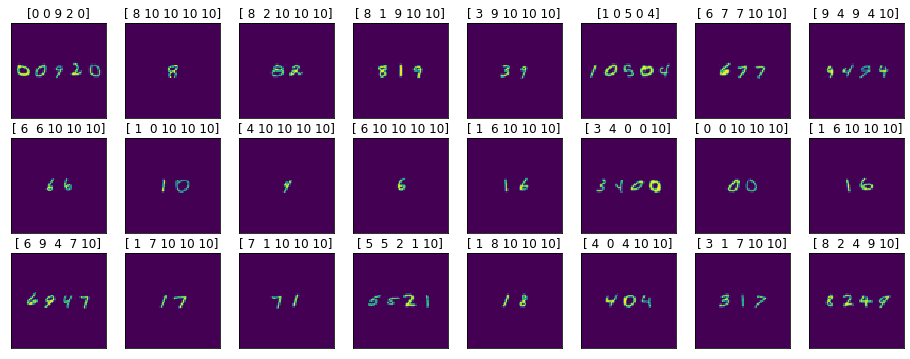

In [36]:
# Shuffle the examples before visualizing
X_new, y_new = shuffle(X_new, y_new, random_state=0)

# Plot 3 rows of 8 images from the new dataset
plot_images(X_new, y_new, 3, 8)

### Training, Test and Validation Sets

Let's split our dataset and create a training, test and validation set

In [38]:
from sklearn.model_selection import train_test_split

# Create a training and test set
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new)

# Select some random images to be used in our validation set
idx = np.random.choice(range(0, len(X_test)), size=int(len(X_test)*0.20), replace=False)

# Construct our validation set and remove the images from the test set
X_val, y_val = X_test[idx], y_test[idx]

# Remove the validation samples from the testset
X_test = np.delete(X_test, idx, axis=0)
y_test = np.delete(y_test, idx, axis=0)

print("Training", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)
print('Validation', X_val.shape, y_val.shape)

Training (7500, 64, 64, 1) (7500, 5)
Test (2000, 64, 64, 1) (2000, 5)
Validation (500, 64, 64, 1) (500, 5)


## Storing the Data

Let's store our new datasets in a h5py file that we will use as model input.

In [46]:
import h5py

# Create file
h5f = h5py.File('MNIST_synthetic.h5', 'w')

# Store the datasets
h5f.create_dataset('train_dataset', data=X_train)
h5f.create_dataset('train_labels', data=y_train)
h5f.create_dataset('test_dataset', data=X_test)
h5f.create_dataset('test_labels', data=y_test)
h5f.create_dataset('valid_dataset', data=X_val)
h5f.create_dataset('valid_labels', data=y_val)

# Close the file
h5f.close()